# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg
[image3]: ./examples/sliding_windows.jpg
[image4]: ./examples/sliding_window.jpg
[image5]: ./examples/bboxes_and_heat.png
[image6]: ./examples/labels_map.png
[image7]: ./examples/output_bboxes.png
[video1]: ./project_video.mp4

## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation. 

---
### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!


### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the code cells below.  

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:


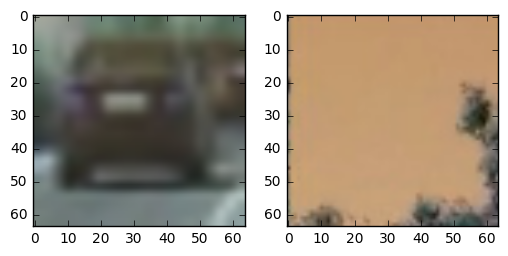

In [1]:
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline

# Read in car and non-car images
images = glob.glob('**/*.png', recursive=True)
cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    elif 'vehicles' in image:
        cars.append(image)

car_example = cv2.imread(cars[0])
notcar_example = cv2.imread(notcars[0])
        
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(car_example)
axarr[1].imshow(notcar_example)



I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.


In [2]:
from skimage.feature import hog
pix_per_cell = 8
cell_per_block = 2
orient = 9
color_channels = ['GRAY', 'RED', 'BLUE', 'GREEN', 'H', 'L', 'S', 'U', 'V']
image = cars[666]

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=False, feature_vector=feature_vec)
        return features

    
def plot_example(img, pix_per_cell, cell_per_block, orient, channel):
    image = cv2.imread(img)
    if channel == 'GRAY':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, hog_image = get_hog_features(image[:, :], pix_per_cell, cell_per_block, orient, vis=True)
    elif channel == 'RED':
        _, hog_image = get_hog_features(image[:, :, 2], pix_per_cell, cell_per_block, orient, vis=True)
    elif channel == 'BLUE':
        _, hog_image = get_hog_features(image[:, :, 0], pix_per_cell, cell_per_block, orient, vis=True)
    elif channel == 'GREEN':
        _, hog_image = get_hog_features(image[:, :, 1], pix_per_cell, cell_per_block, orient, vis=True)
    elif channel == 'H':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        _, hog_image = get_hog_features(image[:, :, 0], pix_per_cell, cell_per_block, orient, vis=True)
    elif channel == 'L':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        _, hog_image = get_hog_features(image[:, :, 1], pix_per_cell, cell_per_block, orient, vis=True)
    elif channel == 'S':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        _, hog_image = get_hog_features(image[:, :, 2], pix_per_cell, cell_per_block, orient, vis=True)
    elif channel == 'U':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        _, hog_image = get_hog_features(image[:, :, 1], pix_per_cell, cell_per_block, orient, vis=True)
    elif channel == 'V':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        _, hog_image = get_hog_features(image[:, :, 2], pix_per_cell, cell_per_block, orient, vis=True)
            
    return hog_image

Here is an example using the `gray` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:

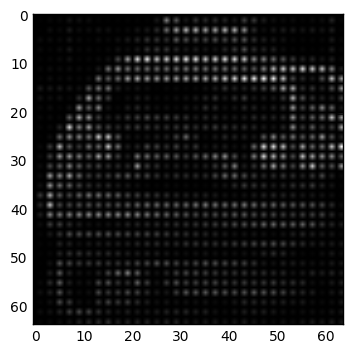

In [3]:
hog_image = plot_example(image, pix_per_cell=8, cell_per_block=2, orient=8, channel='GRAY')
plt.imshow(hog_image, cmap='gray')

Next, there is an example with 16 pixels per cell, again color channel `GRAY`:

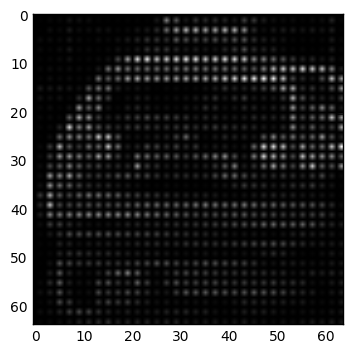

In [4]:
hog_image = plot_example(image, pix_per_cell=16, cell_per_block=2, orient=8, channel='GRAY')
plt.imshow(hog_image, cmap='gray')

The S-channel seems to perform worse to distinguish cars:

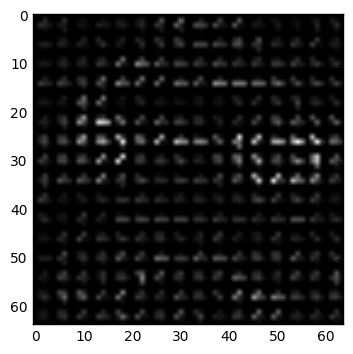

In [5]:
hog_image = plot_example(image, pix_per_cell=8, cell_per_block=4, orient=8, channel='S')
plt.imshow(hog_image, cmap='gray')

Also, with 16 pixels per cell it does not perform as well.

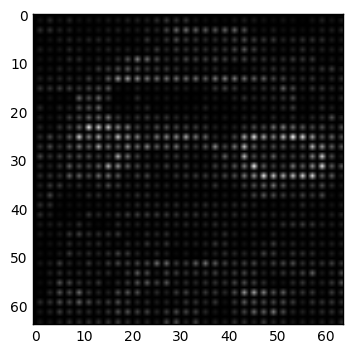

In [6]:
hog_image = plot_example(image, pix_per_cell=16, cell_per_block=2, orient=8, channel='S')
plt.imshow(hog_image, cmap='gray')

#### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of color channels and HOG settings. I fed them into a classifier (together with color histogram features) and used the best performing settings (where best is, of course, defined on a cross-validation set). The best hog feature settings were found to be the following: 

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

The final classifier consisted of three "different kinds" of input features:

+ Features coming from a color histogram
+ raw pixel values
+ HOG features as above

In the next code block, I define the color histogram features: there, I calculate the histogram for the three color channels, conatenate them and return them.

In [7]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Raw pixel features
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

Next, we define a function that returns the feature vector for a single image. Basically, it computes the histogram from above, the hog features from above and additionally gives back the raw pixel values (depending on the colorspace)

In [8]:
import matplotlib.image as mpimg

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

Now, that we have this feature extraction function at hand, we can finally train the classifier. Using cross-validation, it was found that raw pixel features from 'YUV', in combination with 12 HOG orientations and 12 pixels per cell and 2 cells per block work best. Also, there were 32 histogram bins per color channel.

For both the car dataset and the non-car dataset, these features were extracted. Then it was made sure that they are all on the same scale, using the `StandardScaler`. Then these features together with the correct labels were fed into a linear support vector machine with hinge loss function (and otherwise default parameters). The accuracy of the classifier was above 99%.

In [123]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12
pix_per_cell = 12
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)
hist_bins = 32

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2,
                     hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for img in imgs:
        feature_img = cv2.imread(img)
        features.append(single_img_features(feature_img, color_space, spatial_size,
                                           hist_bins, orient, pix_per_cell, cell_per_block,
                                           hog_channel, spatial_feat, hist_feat, hog_feat))
    
    return features

car_features = extract_features(cars, color_space=colorspace, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel, 
                               spatial_feat=True, hist_feat=True, hog_feat=True)

notcar_features = extract_features(notcars, color_space=colorspace, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel, 
                               spatial_feat=True, hist_feat=True, hog_feat=True)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC 
svc = LinearSVC(loss='hinge')

svc.fit(X_train, y_train)

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

Test Accuracy of SVC =  0.9919
My SVC predicts:  [ 1.  0.  0.  0.  1.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  1.  0.  1.  0.  1.  1.]


### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I used three windows sizes all going all the way from left to right

+ (64, 64): they went from 400 to 500 in y-direction
+ (96, 96) from 400 to 500 in y-direction
+ (128, 128) from 450 to 600 in y-direction.

The individual windows and the combination can be seen in the plots below:

In [14]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

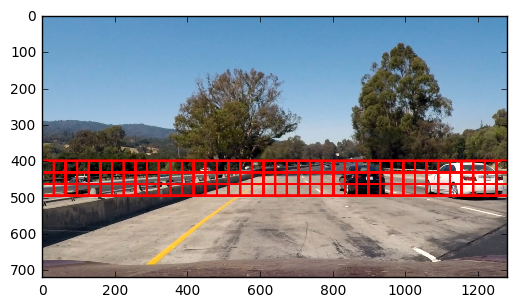

In [106]:
test_img = cv2.imread('./test_images/test1.jpg')
windows1 = slide_window(test_img, x_start_stop=[None, None], y_start_stop=[400, 500], xy_window=(64, 64))
windows2 = slide_window(test_img, x_start_stop=[None, None], y_start_stop=[400, 500], xy_window=(96, 96))
windows3 = slide_window(test_img, x_start_stop=[None, None], y_start_stop=[450, 600], xy_window=(128, 128))
windows4 = slide_window(test_img, x_start_stop=[None, None], y_start_stop=[300, 600], xy_window=(300, 300))

windows = windows1 + windows2 + windows3

plt.imshow(cv2.cvtColor(draw_boxes(test_img, windows1), cv2.COLOR_BGR2RGB))

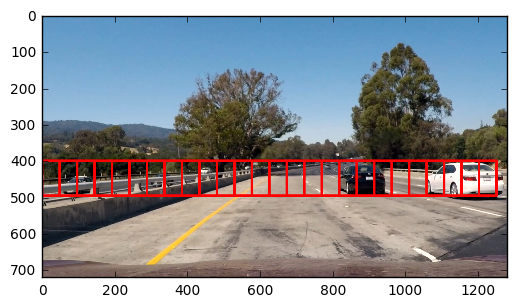

In [107]:
plt.imshow(cv2.cvtColor(draw_boxes(test_img, windows2), cv2.COLOR_BGR2RGB))

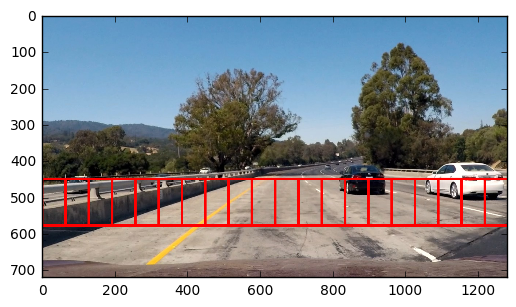

In [108]:
plt.imshow(cv2.cvtColor(draw_boxes(test_img, windows3), cv2.COLOR_BGR2RGB))

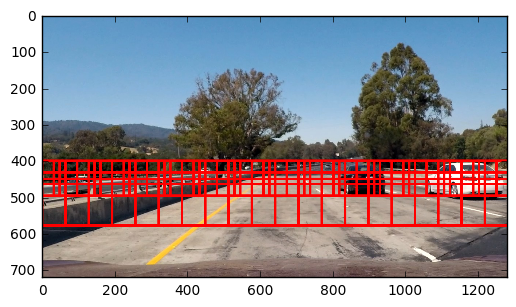

In [110]:
plt.imshow(cv2.cvtColor(draw_boxes(test_img, windows), cv2.COLOR_BGR2RGB))

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to try to minimize false positives and reliably detect cars?

For each of the windows shown above, the classifier was applied. See the examples below.

I tried to minimize false positives on a single image by taking not too many windows: just by accident, the more windows we test, the more false positives wer are going to find. On the other hand, the combination of sliding windows with the classifier described above works reasonsably well to reliably detect cars.

In [138]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

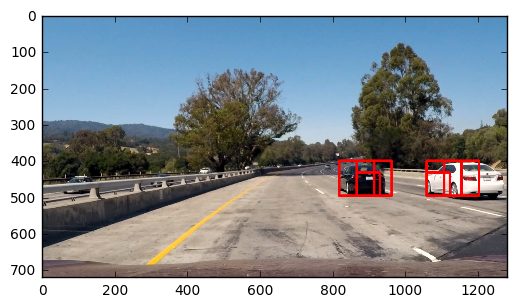

In [112]:
hot_windows = search_windows(test_img, windows, svc, X_scaler, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=True, 
                        hist_feat=True, hog_feat=True)    

plt.imshow(cv2.cvtColor(draw_boxes(test_img, hot_windows), cv2.COLOR_BGR2RGB))

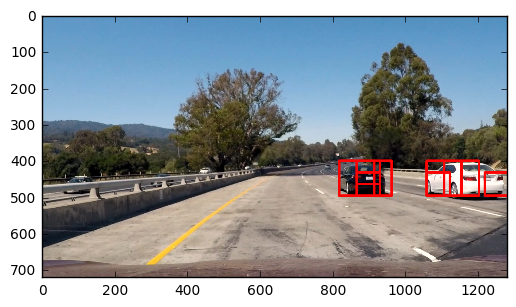

In [142]:
test_img2 = cv2.imread('./test_images/test4.jpg')

hot_windows = search_windows(test_img, windows, svc, X_scaler, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=True, 
                        hist_feat=True, hog_feat=True)    

plt.imshow(cv2.cvtColor(draw_boxes(test_img, hot_windows), cv2.COLOR_BGR2RGB))

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./project_video.mp4)

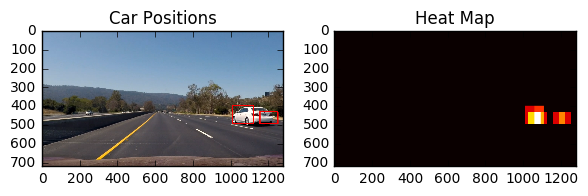

In [151]:
from scipy.ndimage.measurements import label

# Read in series of consecutive images
test_images = glob.glob('./test_images/img_series*', recursive=True)

# Create heatmap
heat = np.zeros_like(test_img[:,:,0]).astype(np.float)

box_list = []
for img in test_images:
    current_img = cv2.imread(img)
    hot_windows = search_windows(current_img, windows, svc, X_scaler, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=True, 
                        hist_feat=True, hog_feat=True)    
    box_list.append(hot_windows)
    box_list = box_list[-6:]

box_list = [item for sublist in box_list for item in sublist]
    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat, box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(current_img), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [ ]:
cap = cv2.VideoCapture('project_video.mp4')
 # Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('project_output.mp4', fourcc, 30, (1280, 720))

box_list = []

#for k in range(1000):
#    ret, frame = cap.read()

count = 0
while(cap.isOpened()):
    count += 1
    ret, frame = cap.read()
    if ret==True:
        frame, box_list = process_image(frame, box_list)
        
        out.write(frame)
    else:
        break
    
    if count % 24 == 0:
        print(count)
    
    #if count > 300:
    #    break
            
cap.release()
out.release()


#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions. The heatmap was constructed by counting how many times a pixel was marked as corresponding to a car in the past 10 video frames. If it has been found to correspond to a car at least 6 times, then it was decided that it really corresponds with a car.

I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap and assumed that each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

### Here are six frames and their corresponding heatmaps:

The integrated result can be seen above.

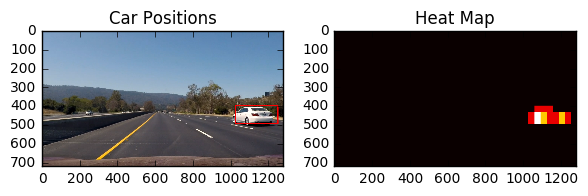

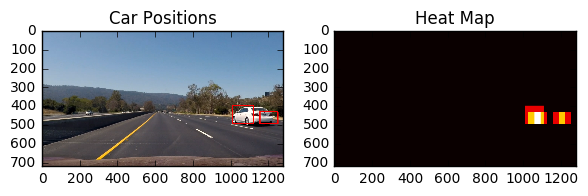

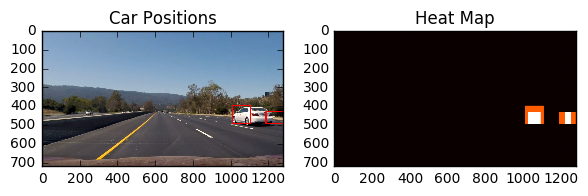

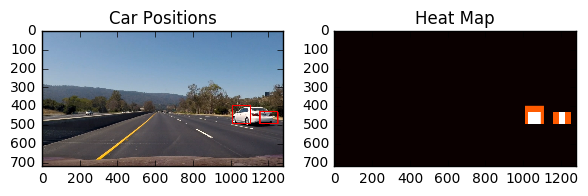

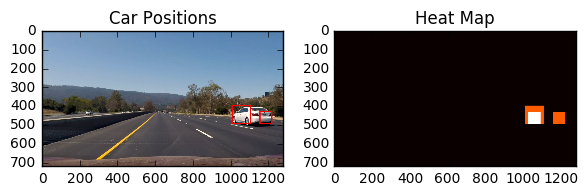

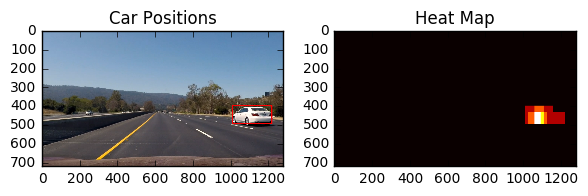

In [155]:
test_images = glob.glob('./test_images/img_series*.png', recursive=True)
for img_path in test_images:
    
    img = cv2.imread(img_path)
    # Create heatmap
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    box_list = []
    
    box_list = search_windows(img, windows, svc, X_scaler, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=True, 
                        hist_feat=True, hog_feat=True) 
    
    
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(current_img), labels)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

At the moment the pipeline is sort of hand tuned, mostly with respect to the window sizes. This can be problematic: for example, consider the situation in which a car gets in front of our car very closely; we would not able to recognize it with the current approach.

I think that a very interesting general approach to this problem is deep learning. Here one could generate synthetic datasets by putting examples of cars and noncars next to and above each other, and then mark the corresponding regions as belonging to cars / non-cars. Then a classifier has to learn many labels at the same time, one for each pixel. This would allow us to remove many manual steps and might make the classifier much more robust. For an example of how such a training image might look like, see below:

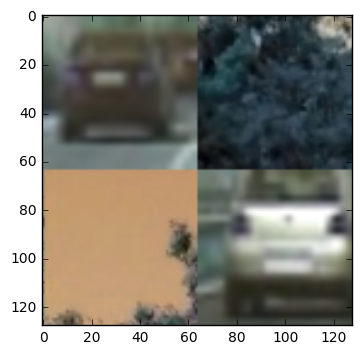

In [171]:
car_example1 = cv2.imread(cars[0])
car_example2 = cv2.imread(cars[100])
notcar_example1 = cv2.imread(notcars[0])
notcar_example2 = cv2.imread(notcars[2])

part1 = np.concatenate([car_example1, notcar_example1])
part2 = np.concatenate([notcar_example2, car_example2])

plt.imshow(np.concatenate([part1, part2], axis=1))